### Установка

In [3]:
# pip install pandas numpy matplotlib scikit-learn sentence_transformers

### Импорт библиотек

In [4]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from sklearn.metrics.pairwise import cosine_similarity
from sentence_transformers import SentenceTransformer

from typing import List

/Users/maxgiga/dev/mai/dead10cc/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## чтение датасета

Используется датасет [bright data](https://github.com/luminati-io/Wildberries-dataset-sample)

При чтении создаем поле описание, чистим повторяющиеся значения оставляем лишь необходимые поля

In [21]:
wb = pd.read_csv("wildberries_sample.csv")

wb = wb.rename(columns={"breadcrumbs":"tag"})
wb['tag'] = wb.tag.apply(lambda x: [i.lower()[1:-1] for i in x[1:-1].split(',') if len(i) > 0])
wb['tag'] = wb.tag.apply(lambda x: [i for i in x if i != "главная"]) # remove useless tag
wb["brand"] = wb["brand"].fillna(value="")
wb['description'] = wb.tag.apply(lambda x: ", ".join(x))
wb["description"] = '[' + wb.brand + '] ' + '[' + wb.brand + '] ' + wb.name + " {" + wb.description + '}'
wb = wb.drop_duplicates(subset=['description'], keep='first')
wb["id"] = range(len(wb))


wb = wb[["id", "sku", "tag", "name", "rating", "review_count", "final_price", "description", "brand"]].set_index("id")

wb

,sku,tag,name,rating,review_count,final_price,description,brand
id,,,,,,,,
0,203812901,"[женщинам, брюки, bona fide]",Тайтсы спортивные для фитнеса с высокой посадк...,4.5,265,4581,[Bona Fide] [Bona Fide] Тайтсы спортивные для ...,Bona Fide
1,3200490,"[женщинам, пиджак, жилеты и жакеты, империя ше...",Жилет утеплённый из овечьей шерсти с капюшоном,4.7,113,0,[Империя Шерсти] [Империя Шерсти] Жилет утеплё...,Империя Шерсти
2,80383323,[],Брэд Питт,5.0,1,479,[и Плакат и Постер] [и Плакат и Постер] Брэд П...,и Плакат и Постер
3,213855491,[],Чехол на Samsung Galaxy A03/Самсунг А03,4.3,24,169,[360skin] [360skin] Чехол на Samsung Galaxy A0...,360skin
4,199321602,"[дом, шторы и портьеры, aruu&home]",Шторы Мрамор для гостиной и спальню 150 на 230,4.6,37,1620,[ARUU&HOME] [ARUU&HOME] Шторы Мрамор для гости...,ARUU&HOME
...,...,...,...,...,...,...,...,...
842,228640189,"[хранение вещей, fankymanky]",Вешалки для одежды деревянные черные набор 10 шт,4.9,74871,1082,[FankyManky] [FankyManky] Вешалки для одежды д...,FankyManky
843,178515690,"[хранение вещей, fankymanky]",Вешалки для одежды деревянные белые набор 10 шт,4.9,74871,1082,[FankyManky] [FankyManky] Вешалки для одежды д...,FankyManky
844,12801486,"[футболки, uzcotton]",Футболка фиолетовая сирень однотонная,4.9,268869,442,[UZcotton] [UZcotton] Футболка фиолетовая сире...,UZcotton


## анализ данных

### тэги присутствующие в датасете

In [22]:
tags = {}
for i in wb["tag"]:
    for i in i:
        if i not in tags:
            tags[i] = 0
        tags[i] += 1

tags = pd.DataFrame.from_records(list(tags.items()), columns=["tag", "count"], index="tag")
tags = tags.sort_values(by="count", ascending=False)
tags

,count
tag,
дом,162
аксессуары,78
женщинам,59
автотовары,59
красота,55
...,...
dymatize,1
carcape,1
recom,1


### производители

In [23]:
brands = wb[["brand", "name"]].groupby("brand").count().rename(columns={"name": "count"})
brands = brands.sort_values(by="count", ascending=False)
brands


,count
brand,
UZcotton,18
PICSIS,10
FankyManky,10
,9
Lefard,7
...,...
Lenardi,1
Les Tropeziennes,1
Licantery,1


### рэйтинги присутствующих товаров

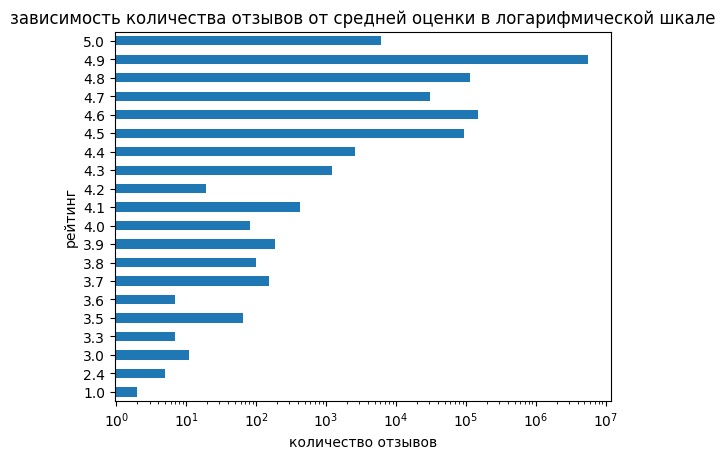

In [24]:
rating = wb[["rating", "review_count"]]

rating = rating.groupby("rating")["review_count"].sum()
rating.plot(kind="barh", logx=True, xlabel="количество отзывов", ylabel="рейтинг", title="зависимость количества отзывов от средней оценки в логарифмической шкале")
plt.show()

## Модель
Используется модель [SentenceBERT](https://www.sbert.net) для предложения товаров с похожим именем и производителем. Полученные товары сортируются по рейтингу

### Инициализируем модель и вычисляем совпадение

In [25]:
bert = SentenceTransformer('bert-base-nli-mean-tokens')

#Get Embeddings for movie overviews
sentence_embeddings = bert.encode(wb['description'].tolist(), show_progress_bar=True)

#Compute similarity between movie overviews
similarity = cosine_similarity(sentence_embeddings)

Batches: 100%|██████████| 27/27 [00:04<00:00,  6.66it/s]


### Вспомогательная функция для возвращения повторений

In [26]:


def getRecomendation(sku: int, n: int = 10) -> List[int]:
    id = wb[wb.sku == sku].index.values[0]
    result = similarity[id]
    recommendations = sorted(list(enumerate(result)), key = lambda x:x[1], reverse = True)
    return [i[0] for i in recommendations[:n]]


In [27]:
recomend = getRecomendation(199321602)

wb[wb.index.isin(recomend)]


,sku,tag,name,rating,review_count,final_price,description,brand
id,,,,,,,,
4,199321602,"[дом, шторы и портьеры, aruu&home]",Шторы Мрамор для гостиной и спальню 150 на 230,4.6,37,1620,[ARUU&HOME] [ARUU&HOME] Шторы Мрамор для гости...,ARUU&HOME
156,187656624,"[дом, свечи и подсвечники, g.t. home]",Свеча Зимняя Ель восковая,4.6,127,318,[G.T. Home] [G.T. Home] Свеча Зимняя Ель воско...,G.T. Home
228,54949075,"[дом, наборы ниток и катушек, gutermann]",Нить Maraflex для трикотажных материалов 150 м...,5.0,102,361,[Gutermann] [Gutermann] Нить Maraflex для трик...,Gutermann
293,67212160,[],Торцевая площадка 140 сталь для круглых воздух...,4.8,569,426,[Era] [Era] Торцевая площадка 140 сталь для кр...,Era
442,167094523,"[дом, одеяла, skandia home]",Демисезонное евро одеяло 200х215 см,4.9,112,1272,[Skandia Home] [Skandia Home] Демисезонное евр...,Skandia Home
590,151982544,[],Тюль в гостиную и спальную 270х600 шторы,4.6,79,1133,[DIO & HOME] [DIO & HOME] Тюль в гостиную и сп...,DIO & HOME
593,190441409,"[сад и дача, полив и водоснабжение, устройства...",Система капельного полива 14 шт,4.3,6,1247,[Design for Home] [Design for Home] Система ка...,Design for Home
607,14833989,"[дом, простыни, inimi home]",Простыня на резинке 90х200 см натяжная трикота...,4.8,397,610,[INIMI HOME] [INIMI HOME] Простыня на резинке ...,INIMI HOME
668,172627532,"[дом, аксессуары для напитков, homemedium/ фор...",Силиконовая форма для льда с крышкой посуда дл...,4.8,41,229,[HomeMedium/ Формочки контейнер для заморозки]...,HomeMedium/ Формочки контейнер для заморозки
